## Smoker Data

### 01 데이터살펴보기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

path = '/content/drive/MyDrive/Datathon_1/'

train_dt = pd.read_csv(path + 'train.csv')
origin_train = pd.read_csv(path + 'original_train.csv')


In [6]:
train_dt['smoking'].value_counts()

,count
smoking,
0,89603
1,69653


In [7]:
train_dt.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [8]:
train_dt['smoking'].value_counts() # class-imbalance 문제 걱정X

,count
smoking,
0,89603
1,69653


In [9]:
origin_train['smoking'].value_counts()

,count
smoking,
0,24666
1,14318


In [10]:
origin_train['hearing(left)'].value_counts() # 1/2가 아니라 0/1로 이진화 필요 'hearing(right)'도 마찬가지!

,count
hearing(left),
1,37995
2,989


In [11]:
# 원래 데이터 비율 차이가 남! (가장 기본적인걸 체크 안함!)
p1 = 69653/(69653+89603)
p2 = 14318/(14318+24666)
print(f'원래데이터 흡연율 : {round(p1*100,2)}%, 추가할데이터 흡연율 : {round(p2*100,2)}%')

원래데이터 흡연율 : 43.74%, 추가할데이터 흡연율 : 36.73%


### 02 EDA(탐색적 데이터 분석)

#### 02-01 데이터 병합!
- 원래 분석 대상의 원본 데이터와의 병합(우리가 분석해야 할 데이터는, 원본 데이터로부터 GAN을 통해 생성된 데이터임)
- 혹시 모를 중복 제거해야 하며, 원본 데이터의 id는 살림!
- 우리 원래 분석대상이면 0, 추가된 데이터는 1로 표기!

In [12]:
import pandas as pd

# 1. 원본 데이터 보존 및 출처(source) 태그 추가
def prepare_dataset(train_df: pd.DataFrame, origin_df: pd.DataFrame) -> pd.DataFrame:
    train_df = train_df.copy()
    origin_df = origin_df.copy()

    train_df['source'] = 0  # 분석용 데이터
    origin_df['source'] = 1  # 원본 데이터

    # 2. 이진화: hearing (1 → 0, 2 → 1)
    for col in ['hearing(left)', 'hearing(right)']:
        train_df[col] = train_df[col].replace({1: 0, 2: 1})
        origin_df[col] = origin_df[col].replace({1: 0, 2: 1})

    # 3. 데이터 병합 (index 무시)
    combined = pd.concat([train_df, origin_df], ignore_index=True)

    # 4. 이상치 제거: 시력 9.9 값 제거
    mask = (combined['eyesight(left)'] != 9.9) & (combined['eyesight(right)'] != 9.9)
    combined = combined[mask]

    # 5. origin 데이터에서 중복 제거 (id/smoking/source 제외)
    origin_only = combined[combined['source'] == 1]
    dedup_cols = [col for col in combined.columns if col not in ['id', 'smoking', 'source']]
    origin_only = origin_only.drop_duplicates(subset=dedup_cols, keep='first')

    # 6. 분석 대상용 데이터와 병합된 중복 제거 origin 데이터 결합
    final = pd.concat([train_df, origin_only], ignore_index=True)

    return final

# 함수 호출
combine_raw = prepare_dataset(train_dt, origin_train)

In [13]:
# (윗 코드의 결측치 제거 로직 주석처리하고 계산함)
# # 코드 실행 후 이 부분은 주석 처리 할 것
# import pandas as pd

# cross_tab = pd.crosstab(combine_raw['smoking'], combine_raw['source'])
# print(cross_tab)

In [14]:
# 중복 제거 후(윗 코드의 결측치 제거 로직 주석처리하고 계산함)

p1 = 69653/(69653+89603)
p2 = 12258/(12258+21209)

print(round(p1*100,2))
print(round(p2*100,2))

43.74
36.63


In [15]:
combine_raw.shape

(192610, 25)

#### 02-02 이상치처리 및 전처리
- eyesight(left) : 9.9는 측정불가한 값(NA)가 숫자로 표현된 것, 제거!
  - test data는 train 데이터의 결측치 제외한 중앙값으로 대체
- eyesight(right) : 9.9는 측정불가한 값(NA)가 숫자로 표현된 것, 제거!
  - test data는 train 데이터의 결측치 제외한 중앙값으로 대체
- 수치형변수 중 이상치비율(참고)
  - fasting blood sugar (5.12%) -> (5.52% 전체)
  - serum creatinine (3.73%) -> (4.07% 전체)
  - AST(3.98%) -> (4.36%)
  - ALT(4.24%) -> (4.62%)
  - Gtp(5.52%) -> (6.1%)

In [16]:
## outlier 확인하는 함수 정의
import numpy as np

def my_outlier(x, k=1.5):
  Q1 = np.percentile(x,25)
  Q3 = np.percentile(x,75)
  IQR = Q3-Q1
  outlier_lower = Q1 - k * IQR
  outlier_upper = Q3 + k * IQR
  return (x < outlier_lower) | (x > outlier_upper)


In [17]:
x_col_list = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries']

outlier_ratio = {}

for col in x_col_list:
  mask = my_outlier(combine_raw[col])
  outlier_ratio[col] = round(mask.mean()*100,2) # 100% 비율로 표현

In [18]:
# eyesight 결측치 제거!
combine_raw = combine_raw[(combine_raw['eyesight(left)'] != 9.9) & (combine_raw['eyesight(right)'] != 9.9)]

In [19]:
# hearing(left), hearing(rihgt) 처리하기!

for col in ['hearing(left)', 'hearing(right)']:
  combine_raw[col] = combine_raw[col].replace({1:0, 2:1})

In [20]:
outlier_ratio

{'age': np.float64(0.45),
 'height(cm)': np.float64(0.32),
 'weight(kg)': np.float64(0.24),
 'waist(cm)': np.float64(0.6),
 'eyesight(left)': np.float64(1.59),
 'eyesight(right)': np.float64(1.69),
 'hearing(left)': np.float64(2.42),
 'hearing(right)': np.float64(2.38),
 'systolic': np.float64(0.95),
 'relaxation': np.float64(0.73),
 'fasting blood sugar': np.float64(5.52),
 'Cholesterol': np.float64(0.61),
 'triglyceride': np.float64(2.24),
 'HDL': np.float64(1.22),
 'LDL': np.float64(0.51),
 'hemoglobin': np.float64(1.07),
 'Urine protein': np.float64(5.31),
 'serum creatinine': np.float64(4.07),
 'AST': np.float64(4.36),
 'ALT': np.float64(4.62),
 'Gtp': np.float64(6.1),
 'dental caries': np.float64(20.09)}

#### 02-03 데이터시각화

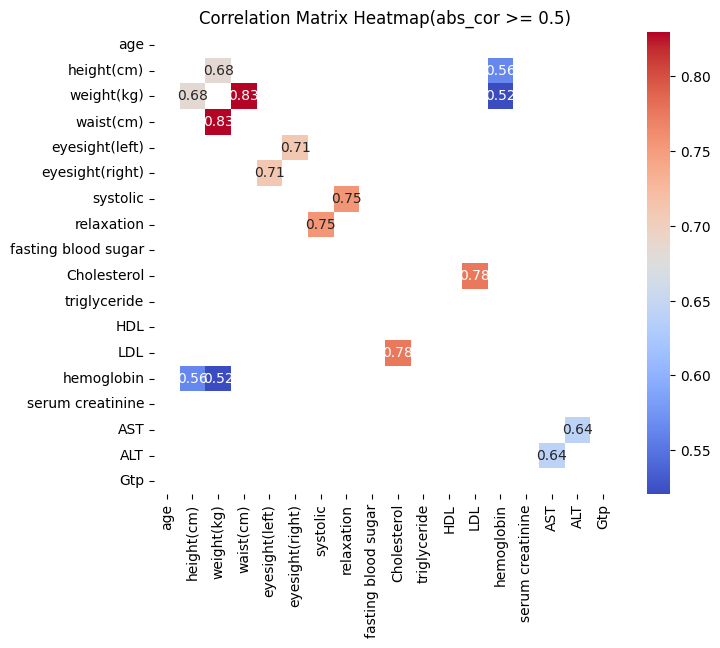

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

x_numeric_feature = ['age','height(cm)','weight(kg)','waist(cm)','eyesight(left)',
                     'eyesight(right)','systolic','relaxation','fasting blood sugar','Cholesterol',
                     'triglyceride','HDL','LDL','hemoglobin','serum creatinine',
                     'AST','ALT','Gtp']
corr_matrix = combine_raw[x_numeric_feature].corr()

# 절대값 기준 0.5 이상 필터링 (자기 자신 제외)
filtered_corr = corr_matrix[(abs(corr_matrix) >= 0.5) & (abs(corr_matrix) < 1.0)]

plt.figure(figsize = (8,6))
sns.heatmap(filtered_corr,annot=True,fmt='.2f',cmap='coolwarm',square=True)
plt.title('Correlation Matrix Heatmap(abs_cor >= 0.5)')
plt.show()

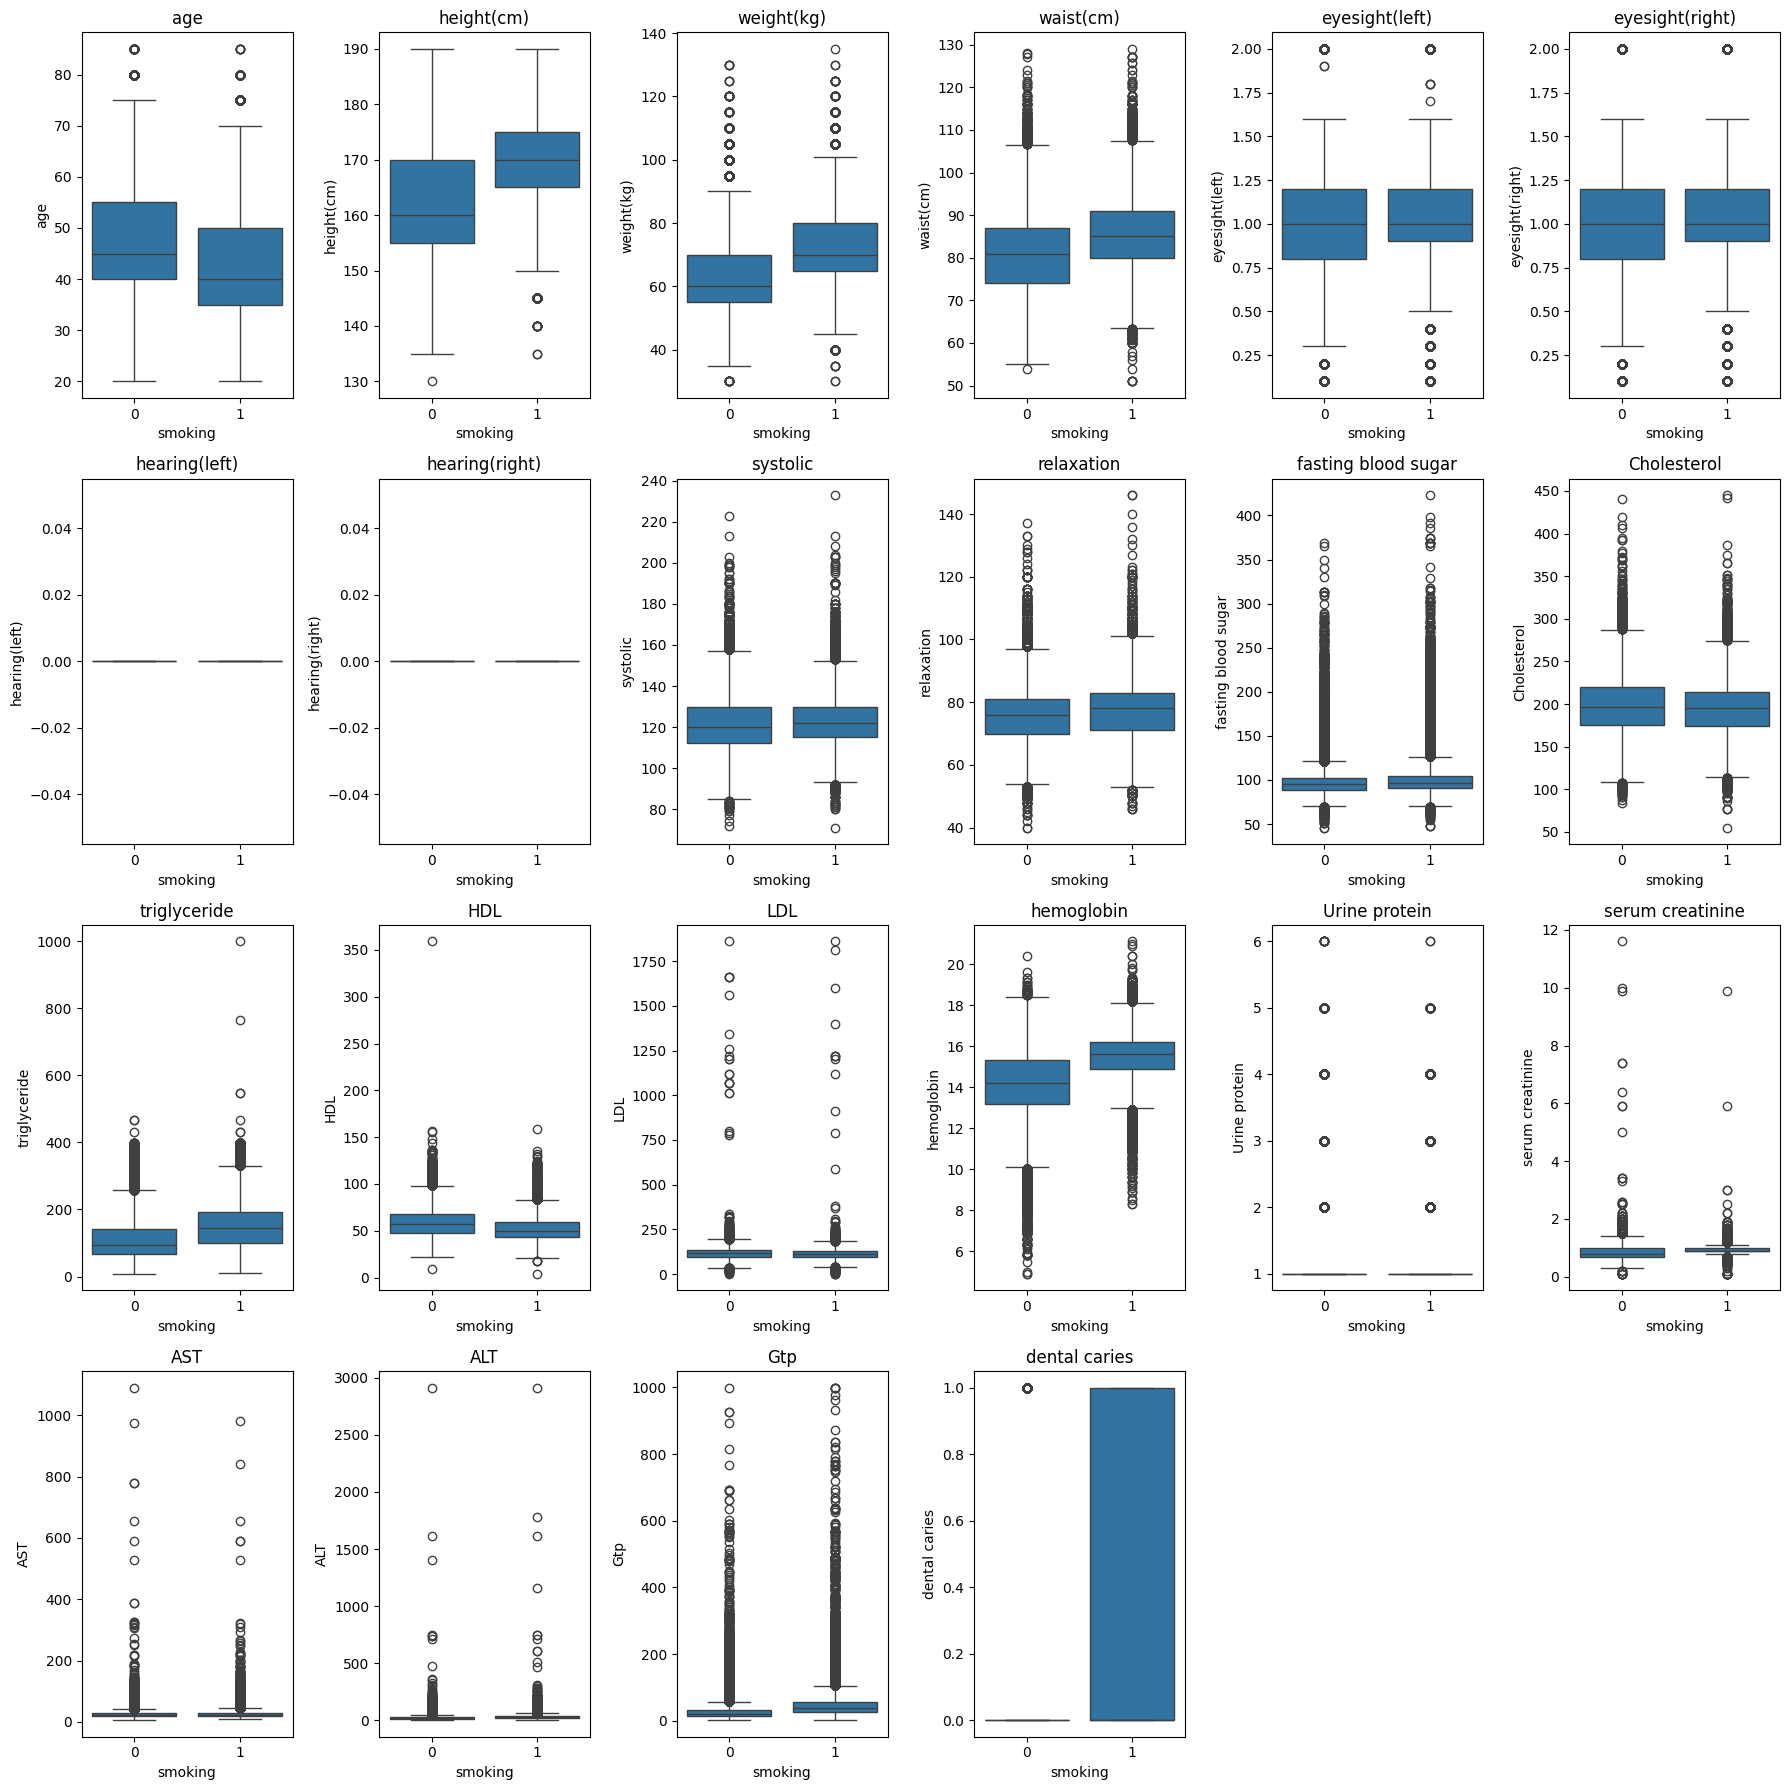

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 18))
axes = axes.flatten()  # 2D를 1D 배열로 바꿔서 편하게 인덱싱

for i, col in enumerate(x_col_list):
    sns.boxplot(x='smoking', y=col, data=combine_raw, ax=axes[i])
    axes[i].set_title(col)

# 남은 subplot 빈칸 지우기 (변수 21개니까 25개 중 4개는 남음)
for j in range(len(x_col_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 02-04 Feature-engineering
- 생각해 볼 만한 Feature
 - BMI
 - 허리둘레/키 비율 (채택)
 - 간 점수 : AST + ALT + Gtp (채택)
 - HDL/LDL 비율
 - 중성지방/LDL 비율(인슐린 저항성) : Triglycerid/(1+ HDL)
 - 양안시력차 : 절대값(왼쪽 눈 시력 - 오른쪽 눈 시력) (채택)
- 결론
 - 데이터 출처(0/1), 간 점수, 양안시력차, 허리둘레/키 비율 추가시
   모델 탐색(parameter-tuning전) 과정에서 최적의 성능을 냄

In [23]:
combine_dt = combine_raw.copy()
combine_dt['waist_height_ratio'] = combine_dt['waist(cm)'] / combine_dt['height(cm)']
combine_dt['liver_score'] = combine_dt['AST'] + combine_dt['ALT'] + combine_dt['Gtp']
combine_dt['eyesight_gap'] = abs(combine_dt['eyesight(left)']- combine_dt['eyesight(right)'])

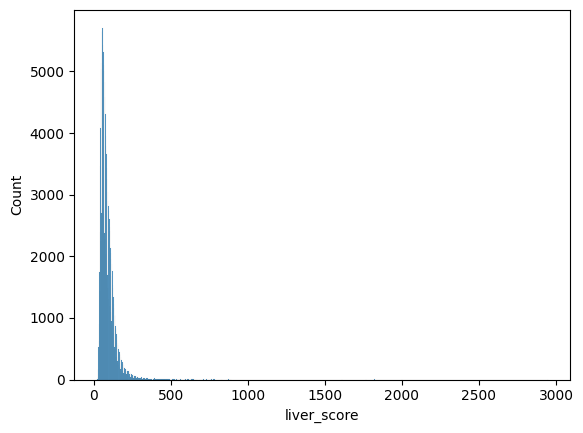

In [ ]:
# sns.histplot(combine_dt['liver_score'])
# plt.show()

In [24]:
# 수치형 컬럼 선택!
numeric_cols = [col for col in combine_dt.columns
                if combine_dt[col].dtype != 'uint8' and
                   combine_dt[col].nunique() > 2 and
                   col != 'smoking' and col != 'id' and col != 'Urine protein']

In [25]:
numeric_cols

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'waist_height_ratio',
 'liver_score',
 'eyesight_gap']

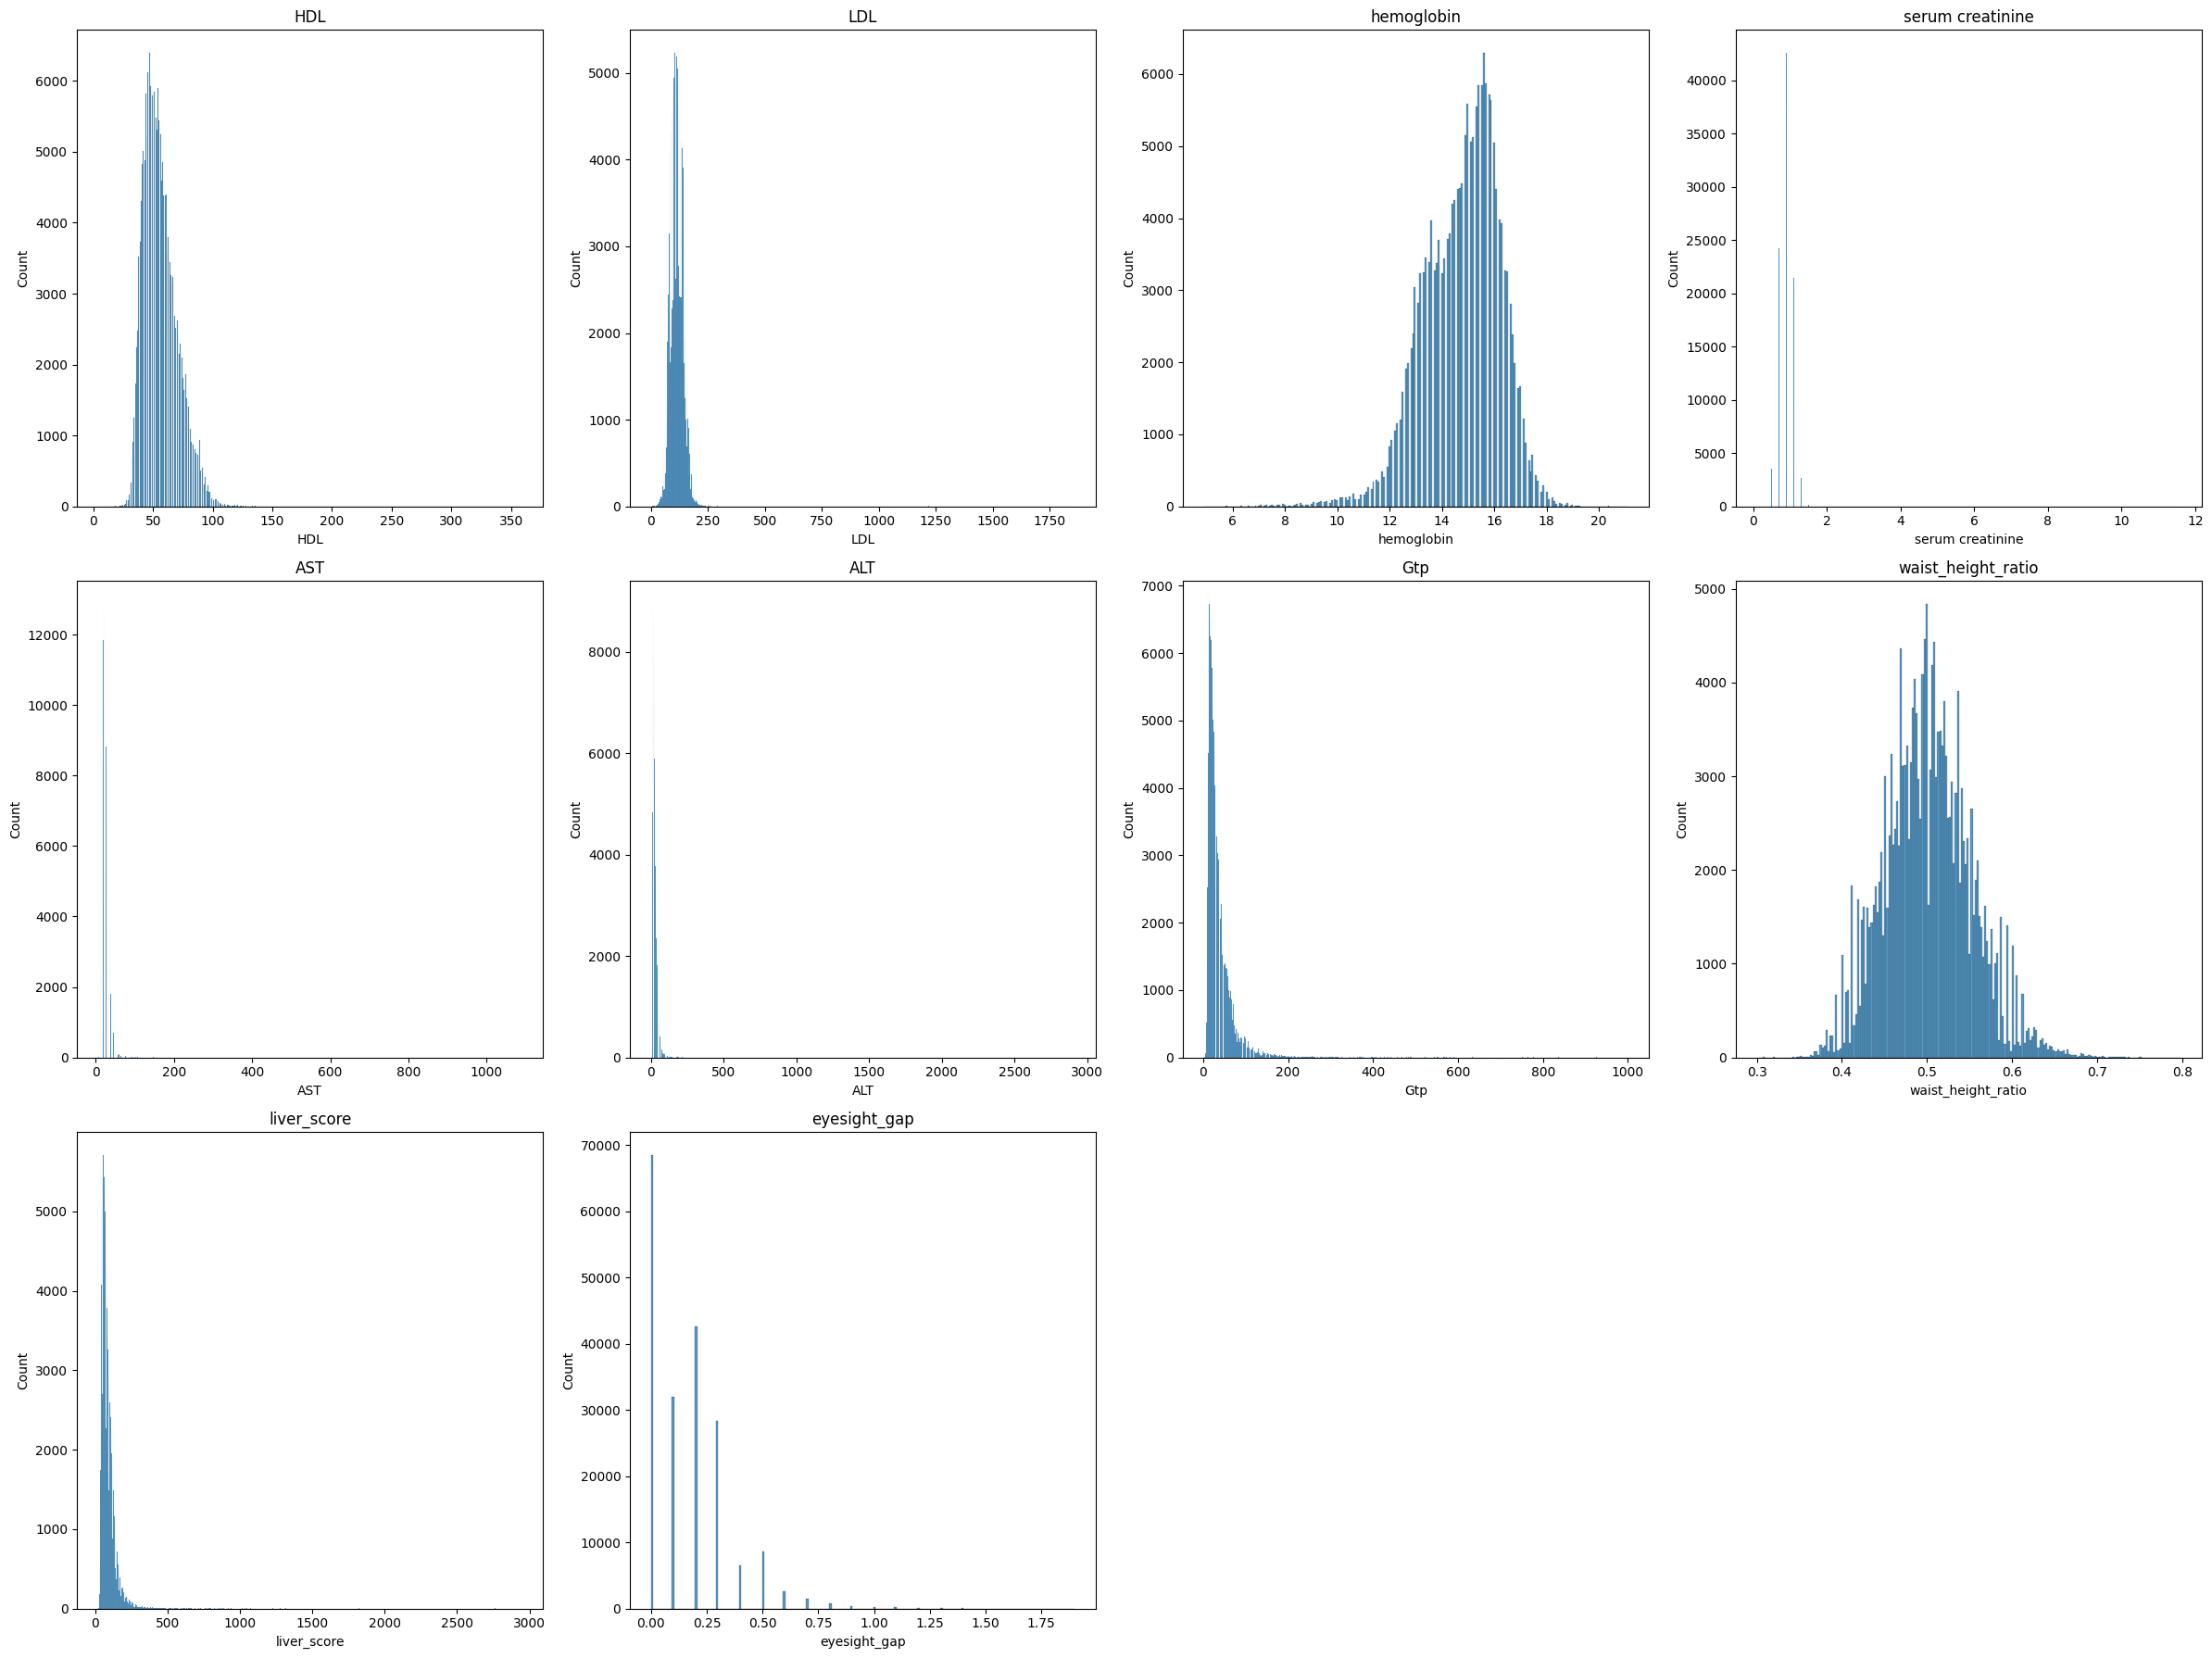

In [26]:
# 수치형 컬럼 데이터 형태/분포 확인(결합된 데이터 기준!)
import matplotlib.pyplot as plt
import seaborn as sns

tmp_numeric = numeric_cols[11:]

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 18))
axes = axes.flatten()  # 2D를 1D 배열로 바꿔서 편하게 인덱싱

for i, col in enumerate(tmp_numeric):
    sns.histplot(x=combine_dt[col], ax=axes[i])
    axes[i].set_title(col)

# 남은 subplot 빈칸 지우기 (변수 22개니까 25개 중 3개는 남음)
for j in range(len(tmp_numeric), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
# Tree아닌 것, Tree모형 모두 log1p 변환 공통적으로 적용(일관성 위해!)

from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np
import pandas as pd

log_cols = ['fasting blood sugar', 'triglyceride', 'HDL', 'LDL',
            'serum creatinine', 'AST', 'ALT', 'Gtp','liver_score']  # log1p 변환할 컬럼들

# 1. 로그 변환 (log_cols에 한해)
combine_dt = combine_dt.copy()  # 원본 보존
for col in log_cols:
    if col in combine_dt.columns:
        combine_dt[col] = np.log1p(combine_dt[col])

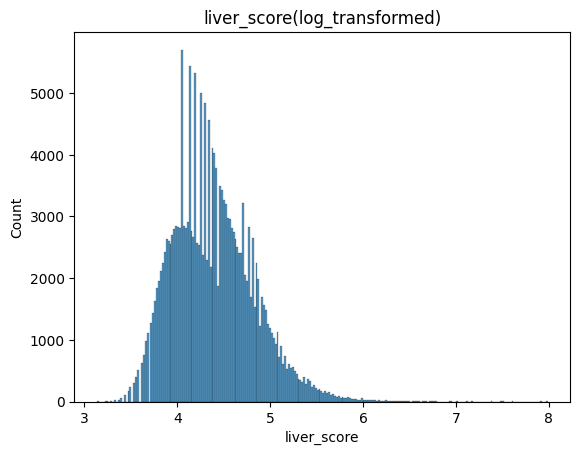

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(combine_dt['liver_score'])
plt.title('liver_score(log_transformed)')
plt.show()

### 03 모델 탐색
- Tree가 아닌 모형
  - 로지스틱, LDA 등이 성능이 우수했으며, 특히 x값이 극히 기울어진 경우 log1p로 변환한 뒤,   
   standardscaler() 적용하면 성능 크게 향상됨(약 0.84수준)
- Tree기반 모형
  - XGboost, Catboost, RandomForest 모두 우수함
  - Catboost가 가장 우수하나, parameter tuning만 잘하면 XG-boost만으로도 충분히 성능이 좋음

#### 03-01 Tree 아닌 모형

##### scaling 진행하기
- one_hot encoding도 잊지 말 것!

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. 데이터 복사
combine_dt = combine_dt.copy()

# 2. 스케일러 정의
scaler = StandardScaler()

# 3. 스케일링 대상 수치형 변수 정의 (이진 변수 및 id, smoking 제외)
numeric_cols = [
    col for col in combine_dt.columns
    if col not in ['id', 'smoking', 'Urine protein'] and
       np.issubdtype(combine_dt[col].dtype, np.number) and
       combine_dt[col].nunique() > 2
]

# 4. 스케일링 수행
scaled_array = scaler.fit_transform(combine_dt[numeric_cols])
scaled_df = pd.DataFrame(scaled_array, columns=numeric_cols, index=combine_dt.index)

# 5. Urine protein에 대해 One-Hot Encoding 수행
urine_encoded = pd.get_dummies(combine_dt['Urine protein'], prefix='urine', drop_first=True).astype(int)

# 6. 최종 결합 (원본에서 스케일링 제외한 컬럼 유지)
combine_scaled_final = pd.concat([
    combine_dt.drop(columns=numeric_cols + ['Urine protein']),
    scaled_df,
    urine_encoded
], axis=1)

# 최종 확인
combine_scaled_final.head()

,id,hearing(left),hearing(right),dental caries,smoking,source,age,height(cm),weight(kg),waist(cm),...,ALT,Gtp,waist_height_ratio,liver_score,eyesight_gap,urine_2,urine_3,urine_4,urine_5,urine_6
0,0.0,0,0,0,1,0,0.904512,-0.019168,-0.548320,-0.203538,...,0.142234,-0.125668,-0.214993,-0.174874,-0.360868,0,0,0,0,0
1,1.0,0,0,1,0,0,2.167936,-0.019168,-0.152942,0.682679,...,-0.022137,0.366663,0.741703,0.190762,-0.360868,0,0,0,0,0
2,2.0,0,0,0,1,0,-2.043479,0.543363,0.637814,-0.203538,...,0.568632,0.933180,-0.499891,0.742394,-0.360868,0,0,0,0,0
3,3.0,0,0,1,0,0,-0.780054,1.668426,2.219325,2.455114,...,0.294418,0.038424,1.608708,-0.085161,0.787345,0,0,0,0,0
4,4.0,0,0,0,1,0,-1.201196,-0.019168,-0.548320,-0.258927,...,-1.128993,-0.837983,-0.274786,-1.102331,1.935559,0,0,0,0,0


In [30]:
combine_scaled_final.columns

Index(['id', 'hearing(left)', 'hearing(right)', 'dental caries', 'smoking',
       'source', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation',
       'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL',
       'hemoglobin', 'serum creatinine', 'AST', 'ALT', 'Gtp',
       'waist_height_ratio', 'liver_score', 'eyesight_gap', 'urine_2',
       'urine_3', 'urine_4', 'urine_5', 'urine_6'],
      dtype='object')

In [31]:
combine_scaled_final['urine_3'].value_counts() # encoding 잘되었는지 체크!

,count
urine_3,
0,189589
1,2780


##### Train/Test 분할
- 7:3 비율, random_state = 42

In [32]:
feature_set = set(combine_scaled_final.columns)
feature_set = feature_set.difference({'id','smoking'})
len(feature_set)

30

In [33]:
X_dt_scale = combine_scaled_final[list(feature_set)]
Y_dt_scale = combine_scaled_final['smoking']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_scale, Y_dt_scale, test_size = 0.3, random_state= 42)

##### 03-01-01 로지스틱

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import time

st = time.time() # 시작시간

lr_base = LogisticRegression(max_iter=100, random_state = 42) # 기본값 100
lr_base.fit(X_train,y_train)
lr_base_pred = lr_base.predict(X_test)

# 1에 대한 예측 확률
lr_base_prob = lr_base.predict_proba(X_test)[:, 1]
# auc 계산
auc = roc_auc_score(y_test,lr_base_prob)

ed = time.time()

print(f"Timespent : {round(ed-st,2)} seconds, ROC_AUC : {auc:.5f}")

Timespent : 4.77 seconds, ROC_AUC : 0.83853


##### 03-01-02 LDA

In [36]:
# 모델 돌리기 전마다 명시할 것!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_scale, Y_dt_scale, test_size = 0.3, random_state= 42)

In [37]:
##### LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import time

st = time.time() # 시작시간

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_pred = lda.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, lda_pred)

ed = time.time()
print(f"Timespent : {round(ed-st,2)} seconds, ROC_AUC : {auc:.5f}")

Timespent : 0.54 seconds, ROC_AUC : 0.83883


##### 03-01-03 SGDClassifier

In [38]:
# 모델 돌리기 전마다 명시할 것!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_scale, Y_dt_scale, test_size = 0.3, random_state= 42)

In [39]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import time

# 1. 시작 시간 기록
st = time.time()

# 2. SGDClassifier (logistic regression과 동일하게 작동)
sgd_clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

# 3. 예측 확률 (decision_function → sigmoid 변환 필요 없음, log_loss는 predict_proba 제공)
sgd_prob = sgd_clf.predict_proba(X_test)[:, 1]  # 1에 대한 확률

# 4. AUC 계산
auc = roc_auc_score(y_test, sgd_prob)

# 5. 종료 시간 기록
ed = time.time()

# 6. 결과 출력
print(f"Timespent : {round(ed - st, 2)} seconds, ROC_AUC : {auc:.5f}")

Timespent : 0.91 seconds, ROC_AUC : 0.83649


##### 03-01-04 모형별 ROC_AUC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 분류기들
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
# 모델 돌리기 전마다 명시할 것!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_scale, Y_dt_scale, test_size = 0.3, random_state= 42)

In [ ]:
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'SGD': SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42),
    'LDA': LinearDiscriminantAnalysis()
}

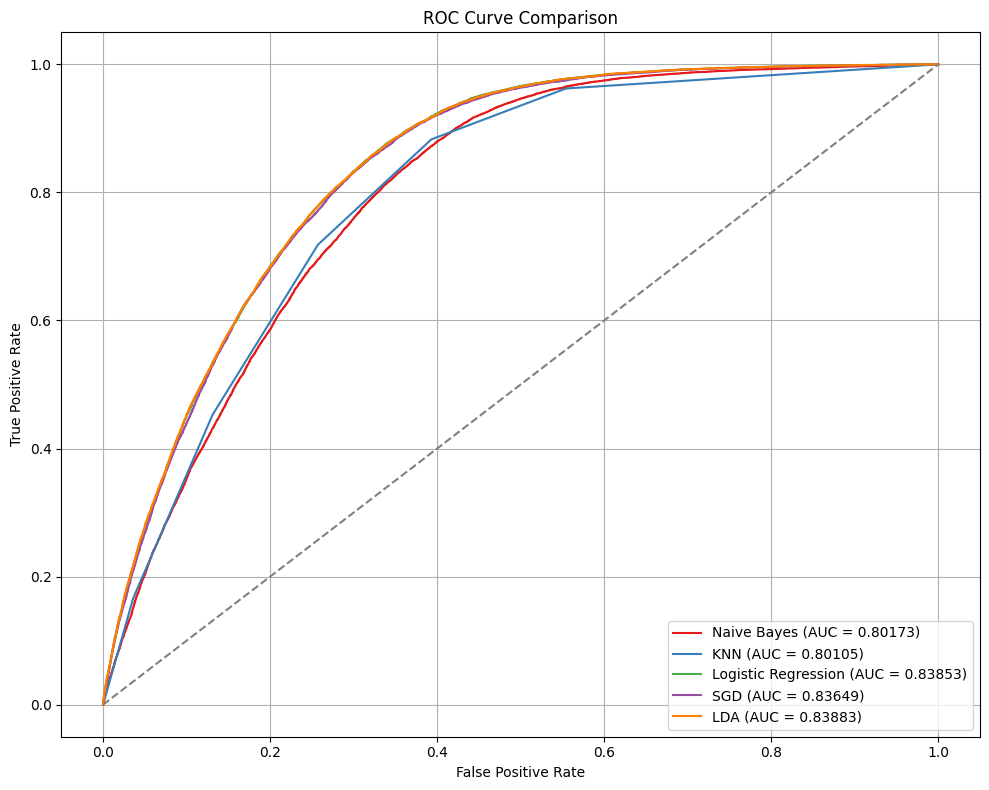

In [ ]:
# 색상 리스트 (matplotlib 컬러맵)
colors = plt.cm.Set1(range(len(models)))

plt.figure(figsize=(10, 8))

for (name, model), color in zip(models.items(), colors):
    model.fit(X_train, y_train)

    # 확률 예측 또는 결정 함수
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    # ROC 곡선 계산 및 시각화
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.5f})", color=color)

# 기준선
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 03-02 Tree 기반 모형

##### 데이터셋구성

In [40]:
import pandas as pd

# 1. 데이터 복사
tree_ready_dt = combine_dt.copy()

# 2. 'Urine protein'을 One-hot 인코딩 (drop_first=True로 다중공선성 방지)
urine_encoded = pd.get_dummies(tree_ready_dt['Urine protein'], prefix='urine', drop_first=True).astype(int)

# 3. 기존 'Urine protein' 제거 후 인코딩 결과 결합
tree_ready_dt = tree_ready_dt.drop(columns=['Urine protein'])
tree_ready_dt = pd.concat([tree_ready_dt, urine_encoded], axis=1)

# 4. 확인
print(f"변환 후 shape: {tree_ready_dt.shape}")
tree_ready_dt.head()

변환 후 shape: (192369, 32)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,smoking,source,waist_height_ratio,liver_score,eyesight_gap,urine_2,urine_3,urine_4,urine_5,urine_6
0,0.0,55,165,60,81.0,0.5,0.6,0,0,135,...,1,0,0.490909,4.317488,0.1,0,0,0,0,0
1,1.0,70,165,65,89.0,0.6,0.7,0,0,146,...,0,0,0.539394,4.477337,0.1,0,0,0,0,0
2,2.0,20,170,75,81.0,0.4,0.5,0,0,118,...,1,0,0.476471,4.718499,0.1,0,0,0,0,0
3,3.0,35,180,95,105.0,1.5,1.2,0,0,131,...,0,0,0.583333,4.356709,0.3,0,0,0,0,0
4,4.0,30,165,60,80.5,1.5,1.0,0,0,121,...,1,0,0.487879,3.912023,0.5,0,0,0,0,0


##### Train/Test 분할

In [41]:
feature_set = set(tree_ready_dt.columns)
feature_set = feature_set.difference({'id','smoking'})
len(feature_set)

30

In [42]:
X_dt_tree = tree_ready_dt[list(feature_set)]
Y_dt_tree = tree_ready_dt['smoking']

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_tree, Y_dt_tree, test_size = 0.3, random_state= 42)

##### 03-02-01 Random-Forest

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_tree, Y_dt_tree, test_size = 0.3, random_state= 42)

In [45]:
# Random-Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import time

st = time.time()
RF_base = RandomForestClassifier(random_state=42)
RF_base.fit(X_train,y_train)
RF_base_pred = RF_base.predict(X_test)

# 1에 대한 예측 확률
RF_base_prob = RF_base.predict_proba(X_test)[:, 1]
# auc 계산
auc = roc_auc_score(y_test,RF_base_prob)

ed = time.time()

print(f"Timespent : {round(ed-st,2)} seconds, ROC_AUC : {auc:.5f}")

Timespent : 63.81 seconds, ROC_AUC : 0.85412


##### 03-02-02 XG-boost

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_tree, Y_dt_tree, test_size = 0.3, random_state= 42)

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import time

st = time.time()
XGB_base = XGBClassifier(random_state=42)
XGB_base.fit(X_train,y_train)
XGB_base_pred = XGB_base.predict(X_test)

# 1에 대한 예측 확률
XGB_base_prob = XGB_base.predict_proba(X_test)[:, 1]
# auc 계산
auc = roc_auc_score(y_test,XGB_base_prob)

ed = time.time()

print(f"Timespent : {round(ed-st,2)} seconds, ROC_AUC : {auc:.5f}")

Timespent : 2.81 seconds, ROC_AUC : 0.86223


##### 03-02-03 LightGBM

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_tree, Y_dt_tree, test_size = 0.3, random_state= 42)

In [49]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import time

st = time.time()
LGBM_base = LGBMClassifier(random_state=42)
LGBM_base.fit(X_train,y_train)
LGBM_base_pred = LGBM_base.predict(X_test)

# 1에 대한 예측 확률
LGBM_base_prob = LGBM_base.predict_proba(X_test)[:, 1]
# auc 계산
auc = roc_auc_score(y_test,LGBM_base_prob)

ed = time.time()

print(f"Timespent : {round(ed-st,2)} seconds, ROC_AUC : {auc:.5f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 57390, number of negative: 77268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 134658, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426191 -> initscore=-0.297410
[LightGBM] [Info] Start training from score -0.297410
Timespent : 4.92 seconds, ROC_AUC : 0.86186


##### 03-02-04 CatBoost

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dt_tree, Y_dt_tree, test_size = 0.3, random_state= 42)

In [51]:
try:
    from catboost import CatBoostClassifier
except ImportError:
    !pip install catboost
    from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [52]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import time

# 1. 시작 시간
st = time.time()

# 2. 모델 정의 (기본 설정: 1000 트리, depth=6, learning_rate=0.03)
cat_model = CatBoostClassifier(
    iterations=1000,
    verbose=0,              # 학습 로그 끄기
    random_seed=42,
    eval_metric='AUC',
    task_type='CPU'         # Colab GPU 사용 시 'GPU'로 설정 가능
)

# 3. 학습
cat_model.fit(X_train, y_train)

# 4. 예측 (확률 기반)
cat_prob = cat_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, cat_prob)

# 5. 시간 종료
ed = time.time()
print(f"Timespent : {round(ed - st, 2)} seconds, ROC_AUC : {auc:.5f}")

Timespent : 99.34 seconds, ROC_AUC : 0.86617


##### 03-02-05 모형별 ROC_AUC

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 57390, number of negative: 77268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 134658, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426191 -> initscore=-0.297410
[LightGBM] [Info] Start training from score -0.297410


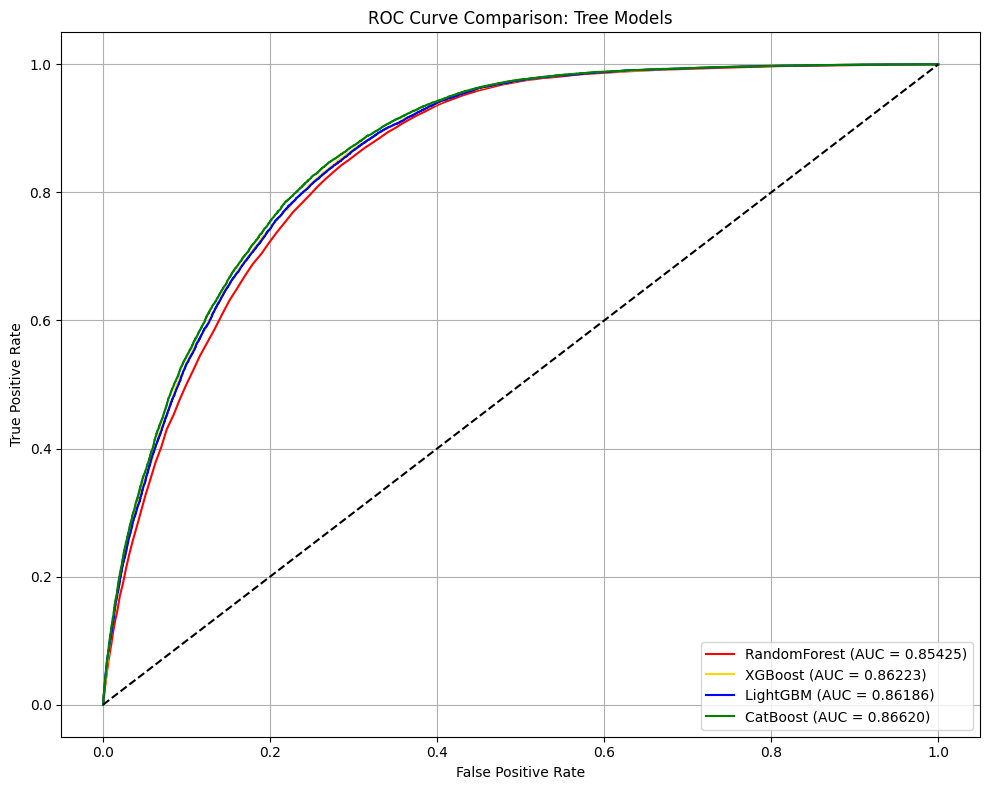

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=42)
}

colors = ['red', 'gold', 'blue', 'green']  # 빨, 노, 파, 초

plt.figure(figsize=(10, 8))

for (name, model), color in zip(models.items(), colors):
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, label=f"{name} (AUC = {roc_auc:.5f})")

plt.plot([0, 1], [0, 1], 'k--')  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Tree Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### 04 모델 튜닝

#### 04-01 XG_boost

In [53]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.2 MB/s eta 0:00:00


In [ ]:
#!pip show xgboost

Name: xgboost
Version: 2.1.4
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: 


In [ ]:
# optuna의 경우 따로 지정 _opt라고 붙여주자!
from sklearn.model_selection import train_test_split
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_dt_tree, Y_dt_tree, test_size = 0.3, random_state= 42)

In [ ]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.07, step=0.005),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'verbosity': 0
    }

    # 데이터 분할
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_opt, y_train_opt, test_size=0.3, random_state=42, stratify=y_train_opt
    )

    # 모델 생성
    model = xgb.XGBClassifier(**params)

    # 학습
    model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val_split, y_val_split)],
        verbose=False
    )

    # 예측 및 평가
    preds_proba = model.predict_proba(X_val_split)[:, 1]
    auc = roc_auc_score(y_val_split, preds_proba)
    return auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-06-03 20:01:54,804] A new study created in memory with name: no-name-2424a493-7e48-431c-9467-fa062f643f7e
[I 2025-06-03 20:02:59,959] Trial 0 finished with value: 0.8586374234414171 and parameters: {'n_estimators': 1137, 'learning_rate': 0.065, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.18247540463840584, 'subsample': 0.65, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 0.8361572763349543, 'reg_lambda': 0.5244961043935001}. Best is trial 0 with value: 0.8586374234414171.
[I 2025-06-03 20:03:52,974] Trial 1 finished with value: 0.8652975400395919 and parameters: {'n_estimators': 1445, 'learning_rate': 0.060000000000000005, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.17555009828786178, 'subsample': 0.6, 'colsample_bytree': 0.75, 'reg_alpha': 0.6960777989140631, 'reg_lambda': 1.6548783492136652}. Best is trial 1 with value: 0.8652975400395919.
[I 2025-06-03 20:04:16,427] Trial 2 finished with value: 0.8664923954769185 and parameters: {'n_estimators': 653, 'lear

Best AUC: 0.8674075905160707
Best Params: {'n_estimators': 1319, 'learning_rate': 0.025, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.7548930274195398, 'subsample': 0.9, 'colsample_bytree': 0.5, 'reg_alpha': 0.6311438168733493, 'reg_lambda': 0.5884105148382658}


In [ ]:
# old parameter, # Best AUC : 0.86647
#  {'n_estimators': 693,
#  'learning_rate': 0.04837073926949571,
#  'max_depth': 6,
#  'min_child_weight': 7,
#  'gamma': 0.034899487989758546,
#  'subsample': 0.970673948742007,
#  'colsample_bytree': 0.6463479415463881,
#  'reg_alpha': 0.45649490608243837,
#  'reg_lambda': 0.7751062700257052}

In [ ]:
# Best AUC : 0.86718 / 0.86819
# 25/06/04/새벽4시22분!
# study.best_params
# {'n_estimators': 979,
#  'learning_rate': 0.046025142287661816,
#  'max_depth': 9,
#  'min_child_weight': 8,
#  'gamma': 0.3816197997237289,
#  'subsample': 0.7796912419422839,
#  'colsample_bytree': 0.63295554692605,
#  'reg_alpha': 0.7782830586960797,
#  'reg_lambda': 0.9126381756424281}

{'n_estimators': 979,
 'learning_rate': 0.046025142287661816,
 'max_depth': 6,
 'min_child_weight': 7,
 'gamma': 0.3816197997237289,
 'subsample': 0.7796912419422839,
 'colsample_bytree': 0.63295554692605,
 'reg_alpha': 0.7782830586960797,
 'reg_lambda': 0.9126381756424281}

In [ ]:
# Best AUC: 0.8674075905160707 / ROC_AUC : 0.86848
# Best Params: {'n_estimators': 1319,
#               'learning_rate': 0.025,
#               'max_depth': 7,
#               'min_child_weight': 5,
#               'gamma': 0.7548930274195398,
#               'subsample': 0.9,
#               'colsample_bytree': 0.5,
#               'reg_alpha': 0.6311438168733493,
#               'reg_lambda': 0.5884105148382658}

In [1]:
# import xgboost
# print(xgboost.__version__)

2.1.4


#### 04-02 체크해보기

In [54]:
# optuna의 경우 따로 지정 _opt라고 붙여주자!
from sklearn.model_selection import train_test_split
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_dt_tree, Y_dt_tree, test_size = 0.3, random_state= 42)

In [69]:
X_train_opt.columns

Index(['weight(kg)', 'hemoglobin', 'HDL', 'eyesight_gap', 'LDL', 'AST',
       'urine_3', 'urine_2', 'eyesight(right)', 'ALT', 'urine_4',
       'triglyceride', 'relaxation', 'waist_height_ratio', 'dental caries',
       'urine_6', 'eyesight(left)', 'serum creatinine', 'hearing(left)', 'Gtp',
       'source', 'height(cm)', 'systolic', 'age', 'fasting blood sugar',
       'waist(cm)', 'hearing(right)', 'urine_5', 'Cholesterol', 'liver_score'],
      dtype='object')

In [55]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import time

st = time.time()
XGB_opt = XGBClassifier(n_estimators = 1319,
                        learning_rate = 0.025,
                        max_depth = 7,
                        min_child_weight = 5,
                        gamma = 0.7548930274195398,
                        subsample = 0.9,
                        colsample_bytree = 0.5,
                        reg_alpha = 0.6311438168733493,
                        reg_lambda = 0.5884105148382658,
                        random_state=42)
XGB_opt.fit(X_train_opt,y_train_opt)
XGB_opt_pred = XGB_opt.predict(X_test_opt)

# 1에 대한 예측 확률
XGB_opt_prob = XGB_opt.predict_proba(X_test_opt)[:,1]
# auc 계산
auc = roc_auc_score(y_test_opt,XGB_opt_prob)

ed = time.time()

print(f"Timespent : {round(ed-st,2)} seconds, ROC_AUC : {auc:.5f}")

Timespent : 47.97 seconds, ROC_AUC : 0.86848


#### 04-03 모델 해석

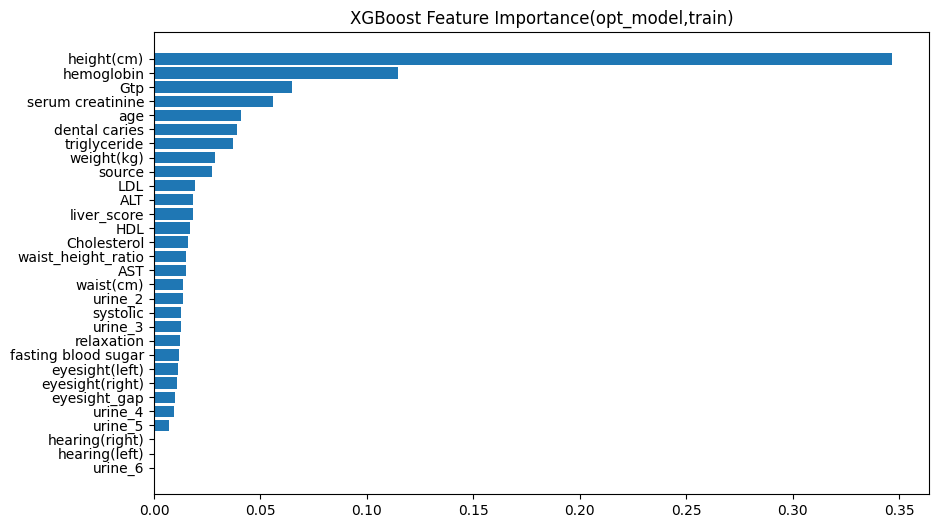

In [62]:
import matplotlib.pyplot as plt
importances = XGB_opt.feature_importances_
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train_opt.columns[i] for i in sorted_idx])
plt.title("XGBoost Feature Importance(opt_model,train)")
plt.show()

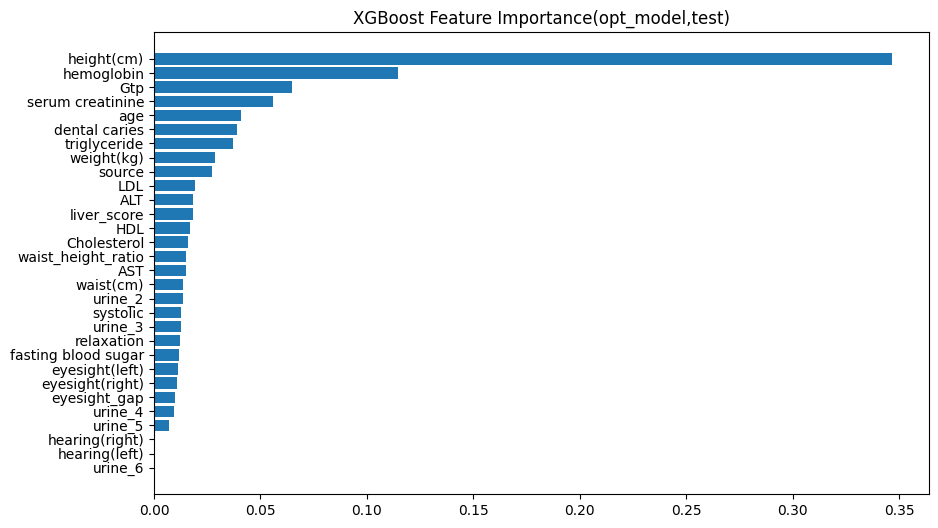

In [63]:
import matplotlib.pyplot as plt
importances2 = XGB_opt.feature_importances_
sorted_idx = importances2.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances2[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_test_opt.columns[i] for i in sorted_idx])
plt.title("XGBoost Feature Importance(opt_model,test)")
plt.show()

In [61]:
importances

array([0.02889531, 0.11470652, 0.01712536, 0.00982774, 0.01911451,
       0.01503519, 0.01259515, 0.01365347, 0.01101885, 0.01838325,
       0.00950041, 0.03705792, 0.01233822, 0.01527018, 0.03890956,
       0.        , 0.01130611, 0.05582027, 0.        , 0.06473026,
       0.02743922, 0.34671623, 0.01283233, 0.04077656, 0.01198976,
       0.01372633, 0.        , 0.00715047, 0.01586148, 0.01821924],
      dtype=float32)

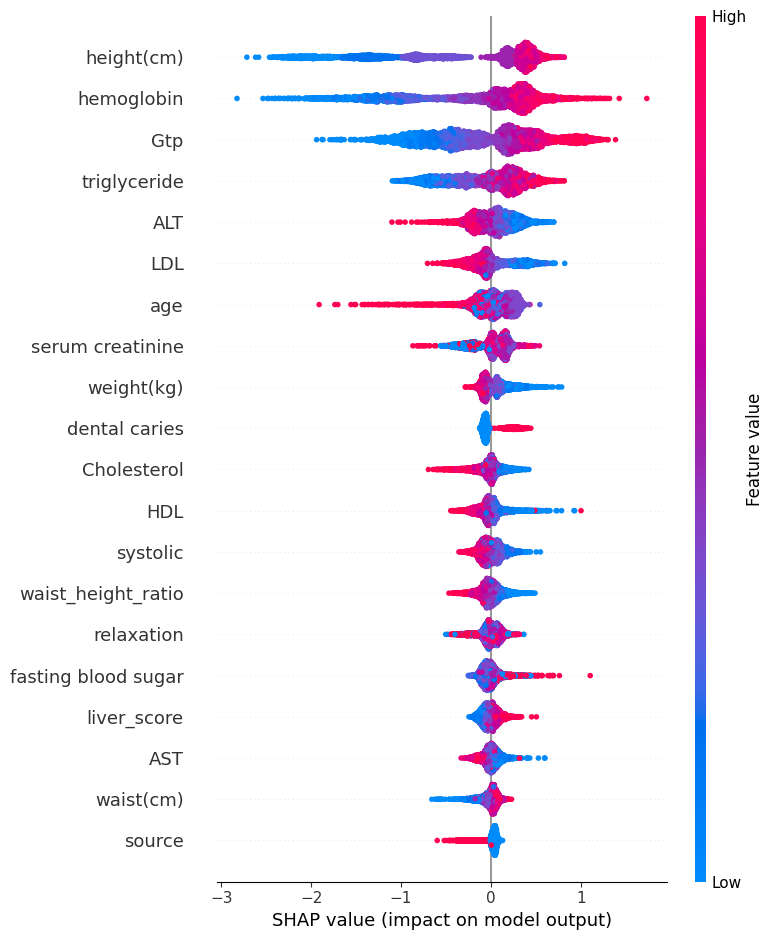

소모시간: 199.75초


In [70]:
# shap 그림 train_set 기준
# 모델이 학습 시 어떤 feature를 중요하게 봤는지 분석
# 일반적으로 feature engineering 검토나 전처리 판단에 적합
import shap
import time

st = time.time()

X_sample = X_train_opt.sample(n=5000, random_state=42)
explainer = shap.Explainer(XGB_opt)
shap_values = explainer(X_sample)

# shap.plots.bar(shap_values) # 한쪽 방향만 보고 싶을 때
# shap.plots.beeswarm(shap_values,) # 중요한 것 10개 정도 추려서 볼 때?!
shap.summary_plot(shap_values, X_sample) # 전체 그림 다 볼 때!

ed = time.time()

print(f'소모시간: {round(ed-st,2)}초')

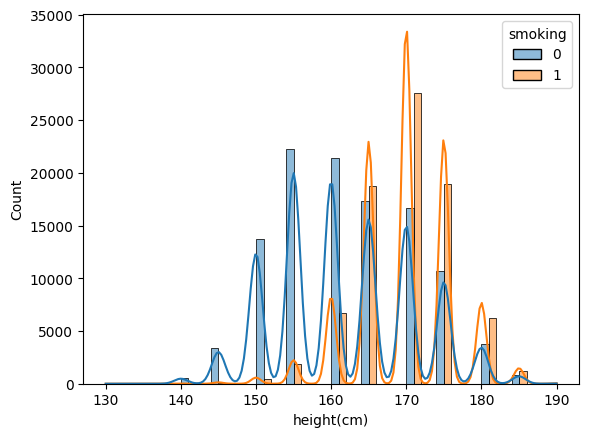

In [75]:
# 단순 시각화이므로 combine_dt로 해도 됨
import seaborn as sns
sns.histplot(data=combine_dt, x='height(cm)', hue='smoking',
             multiple='dodge', bins=30, kde=True)
plt.show()

### 05 모델 결합(voting)

###### 해석
- soft_voting으로는 성능 향상을 유의미하게 이루지 못함
- kaggle 등에서 좋은 성적을 위해서는 더 다양한 모델을 여러개 반영해야 할 듯

In [73]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# ---------------------------
# 1. 데이터 정리
# ---------------------------

# 스케일링된 데이터: 로지스틱, LDA
X_lr = combine_scaled_final.drop(columns=['id', 'smoking'])
y_lr = combine_scaled_final['smoking']

# 트리용 데이터: CatBoost, XGBoost
X_tree = tree_ready_dt.drop(columns=['id', 'smoking'])
y_tree = tree_ready_dt['smoking']

# ---------------------------
# 2. 모델 정의
# ---------------------------

lr = LogisticRegression(max_iter=500, random_state=42)
# lda = LinearDiscriminantAnalysis()
xgb_model = XGBClassifier(n_estimators = 1319,
                          learning_rate = 0.025,
                          max_depth = 7,
                          min_child_weight = 5,
                          gamma = 0.7548930274195398,
                          subsample = 0.9,
                          colsample_bytree = 0.5,
                          reg_alpha = 0.6311438168733493,
                          reg_lambda = 0.5884105148382658,
                          random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_seed=42)

# ---------------------------
# 3. train/test 분리
#    (각 데이터셋에 맞게 따로)
# ---------------------------

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)

# ---------------------------
# 4. 모델 개별 학습
# ---------------------------

lr.fit(X_train_lr, y_train_lr)
lda.fit(X_train_lr, y_train_lr)
xgb_model.fit(X_train_tree, y_train_tree)
cat_model.fit(X_train_tree, y_train_tree)

# ---------------------------
# 5. 확률 예측 (voting용)
# ---------------------------

# 모든 모델이 predict_proba 있어야 함
lr_pred = lr.predict_proba(X_test_lr)[:, 1]
# lda_pred = lda.predict_proba(X_test_lr)[:, 1]
xgb_pred = xgb_model.predict_proba(X_test_tree)[:, 1]
cat_pred = cat_model.predict_proba(X_test_tree)[:, 1]

# Voting은 평균 기반으로 soft voting
# voting_proba = (lr_pred + lda_pred + xgb_pred + cat_pred) / 4
voting_proba = lr_pred * 0.2 + xgb_pred * 0.4 + cat_pred * 0.4

# ---------------------------
# 6. 평가
# ---------------------------

# test set은 같은 기준으로 평가
# 여기서는 y_test_lr ≈ y_test_tree 동일하므로 하나만 사용 가능
print(f"Voting ROC AUC : {roc_auc_score(y_test_lr, voting_proba):.5f}")

Voting ROC AUC : 0.86655
